## Purpose

The goal of this notebook is twofold: first, it is explained the original experiment design since a bayesian perspective. Secondly, it is proposed a evaluation of the conformity of the assumptions taken.

-   [Bayesian Interpretation](#bayes_inter)
-   [Experiment Results](#exp_results)
-   [Discussion - Conformity of assumptions](#diss)

## Bayesian Interpretation 

<a id='bayes_inter'>Bayesian Interpretation </a>

### Theory

We would like to find a better estimate over all possible datasets based on the bayesian evidence for the model described as follows:

The evidence, or marginal likelihood, it the probability we would generate the synthetic dataset D using our beliefs about (1) the generative process and (2) biases of the model. Theorically, it is computed with the following formula:

$P(D \mid M) = \int_ . P(D \mid M, w)P(w)dw$

Formula general interpretation:
    - D: The synthetic dataset 
    - M: the generative model that (we belief) better describe the process that generate that observations (1)
    - w: our prior belief over the parameters of the generative function. This is randomly sampled from the prior over functions y = f(x) and induced from the biases (error) of the model (2)

### Bayesian perspective of the experiment

Once it has been described the theory, here it is explained the bayesian interpretation of the experiment. It is important to recognize the following:

- (1) Generative Model or Support Function
- (2) Inductive biase of the Model 

#### Generative Model or Support Function

The prior belief of the generative model it is described by the underlaying architecture of the neural network. In our case, a simple two-layer feedforward network with 1000 hidden parameters.

#### Inductive bias of the Model

The bias of the model it is estimated from the variance error over the estimated function y = f(x) resulting of the sample parameters sampled from the same error variance of y which it is supposed to be gaussian* 

##### *DUDA*

---> NOTA: Tengo mis dudas de que desde una perpespectiva probabilistica este implicito el conocimiento o prior de que el sampleo de los parámetros venga de una distribucción gaussiana. ¿Es suficiente con asumir que la distribucción del error de la y o el modelo va ser gaussiana? ¿Qué pasa si el modelo no está bien calibrado? En este caso no está formalizado como tal en el experimento y esto es lo que más cuesta para completar la interpretación bayesiana

### Evaluation of the conformity of assumptions

We can evaluate the conformity of the assumptions since we know the underlaying real processes 

#### Real assumptions or process underlaying the generated synthetic dataset

We know that the 'real' process that generate the synthetic dataset is described by the following formula

(2) 'Real' Inductive bias of the Model

$ bias = 0.4 * \sin(x*4*\pi) * error$

sinusoidal error distribution:
    
$error \sim \mathcal{N}(\mu,\,\sigma^{2})\ $

$\mu =0$
$\sigma^{2} =1$

(1) 'Real' Generative Model or Support Function

$ y = 2*x + 1  + bias $

## Experiment Results

<a id='exp_results'>Experiment Results </a>

### Imports 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat

%matplotlib inline

### Generate some random data

In [28]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

### Describe the generated data

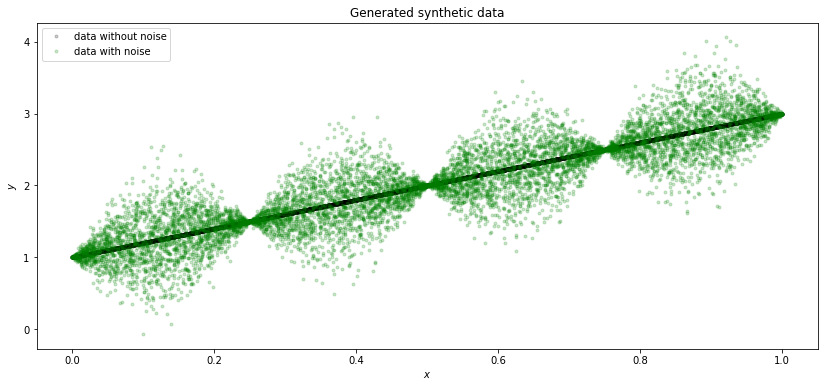

In [29]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x, y_1, '.', alpha=0.2, color='black' ) 
plt.plot(x, y, '.', alpha=0.2, color='green' ) 

plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Prepare data for training

In [5]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y, sigma], axis=1)

In [6]:
# Reshape x for PyTorch
#x = x.reshape(10000, 1)
x = x.reshape(x.size, 1)

In [7]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

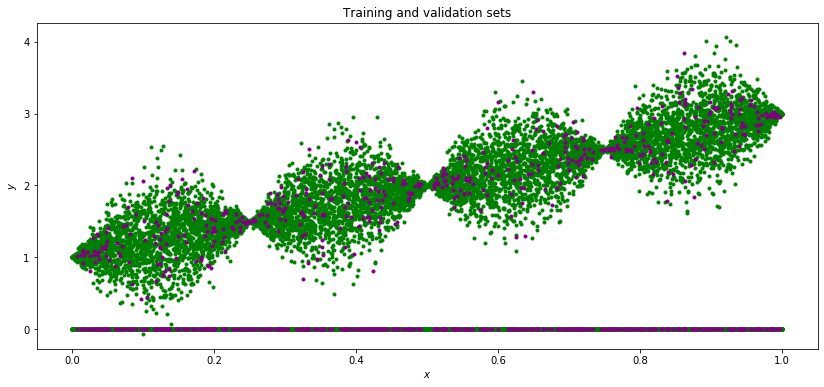

In [8]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [9]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [10]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

## Experiment 

### Create a simple network 

In [11]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [12]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [13]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [14]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 30.4
epoch:  500 loss: 0.0554
epoch: 1000 loss: 0.0532
epoch: 1500 loss: 0.0529
epoch: 2000 loss: 0.0528
epoch: 2500 loss: 0.0527
epoch: 3000 loss: 0.0526
epoch: 3500 loss: 0.0525
epoch: 4000 loss: 0.0524
epoch: 4500 loss: 0.0524
epoch: 5000 loss: 0.0523
epoch: 5500 loss: 0.0522
epoch: 6000 loss: 0.0521
epoch: 6500 loss: 0.052
epoch: 7000 loss: 0.052
epoch: 7500 loss: 0.0519
epoch: 8000 loss: 0.0518
epoch: 8500 loss: 0.0517
epoch: 9000 loss: 0.0516
epoch: 9500 loss: 0.0515


### Get predictions for validation set 

In [18]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

### Plot results

In [25]:
x_extreme = np.arange(1, 1.5, 0.001)
x_extreme = x_extreme.reshape(x_extreme.size, 1)
x_val_ext = Variable(torch.from_numpy(x_extreme).type(dtype)) 

x_val_ext.shape
pred_2 = model_1(x_val_ext)

# prediction of the response variables
y_pred_2 = pred_2[:,0].cpu().data
sigma_pred_2 = pred_2[:,1].cpu().data

C:\Users\yolan\Anaconda3\envs\deep_learning_pytorch\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\yolan\Anaconda3\envs\deep_learning_pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


<Figure size 1008x432 with 0 Axes>

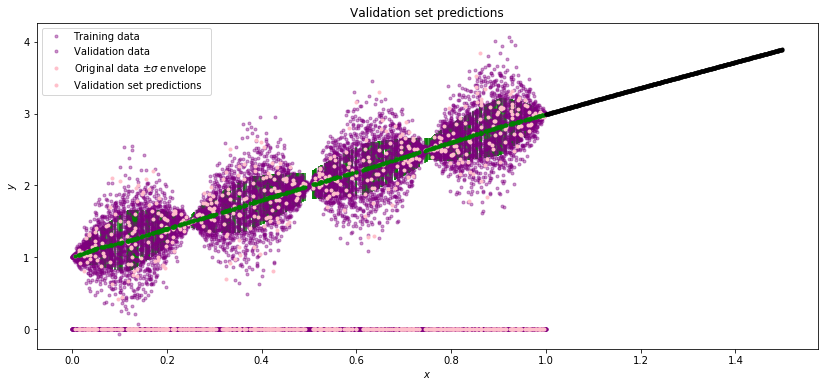

In [26]:
plt.figure(figsize=(14,6))

fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x, y, '.', alpha=0.4, color='purple')
ax1.plot(x_val, y_val, '.', color='pink')
ax1.errorbar(x_val, y_pred_1, yerr=np.sqrt(sigma_pred_1), color='green',fmt='.');
ax1.errorbar(x_val_ext, y_pred_2, yerr=np.sqrt(sigma_pred_2) , color='black', fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
#plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Training data', r'Validation data', r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

### Evaluation of the conformity of this assumptions

<a id='diss'>Discussion - Conformity of assumptions </a>

We know that the 'real' process that generate the synthetic dataset is described by the following formula

(2) 'Real' Inductive bias of the Model

$ bias = 0.4 * \sin(x*4*\pi) * error$

sinusoidal error distribution:
    
$error \sim \mathcal{N}(\mu,\,\sigma^{2})\ $

$\mu =0$
$\sigma^{2} =1$

(1) 'Real' Generative Model or Support Function

$ y = 2*x + 1  + bias $

TODO